## Multi-Language Programming

### Cython

Cython is a superset of the programming language Python, which allows developers to write Python code (with optional, C-inspired syntax extensions) that yields performance comparable to that of C. Most research computing packages include Cython code, for instance scipy, numpy, pandas, scikit-learn, etc.

Typical Cython workflow includes:
1. Convert Python code into Cython code
2. Import C code into Cython code together with Python code
3. Write Cython code inside Python code

To use Cython, we first need to make sure it is installed: !pip install Cython

When converting code into cython, we say we are cythonizing the code; let's compare the performance of cyhton code to python code below:

#### Set Up

In [1]:
import numpy as np
# Create a 2D matrix with size 1000x1000
matrix = [[i * j for j in range(1000)] for i in range(1000)]
matrix_np = np.array(matrix, dtype=np.int32)

Python:

In [2]:
def python_nested_loop(matrix_np):
    total = 0
    for i in range(matrix_np.shape[0]):
        for j in range(matrix_np.shape[1]):
            total += matrix_np[i][j]
    return total

%timeit -r 10 -n 10 python_nested_loop(matrix_np)

/var/folders/qb/pd0pzd3x0jj2c_2nkn2hmrxw0000gn/T/ipykernel_89506/1338800850.py:5: RuntimeWarning: overflow encountered in scalar add
  total += matrix_np[i][j]


80.3 ms ± 2.81 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


Cython:

In [6]:
%load_ext Cython 
#first load cython extension

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [10]:
%%cython 
#indicate that below is cython code (for juypter notebook)

import numpy as np
cimport numpy as np

# Cython function to sum elements of a 2D matrix
def cython_nested_loop(np.ndarray[np.int32_t, ndim=2] matrix): #indicate data type of matrix input
    cdef int total = 0 #create a total variable in int type
    cdef int i, j #indicate that i,j is in int type
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            total += matrix[i, j]
    return total

Content of stderr:
ld: warning: duplicate -rpath '/opt/anaconda3/envs/rc_comput_notes_conda/lib' ignored

In [11]:
%timeit -r 10 -n 10 cython_nested_loop(matrix_np)

783 μs ± 177 μs per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Cython Magic

The Cython implementation is many times faster than the Python implementation. The reasons are listed below:

**Static Typing in Cython:**

**Python:** Variables are dynamically typed, so every operation (e.g., total += matrix[i][j]) requires:
- Checking the types of total, matrix[i], and matrix[i][j].
- Dynamically dispatching the appropriate operation based on those types.

**Cython:** Variables are statically typed (cdef int total, i, j), meaning:
- The types are known at compile time.
- There’s no need for type checking or dynamic dispatch during execution.
- The addition operation (total += matrix[i, j]) is compiled into efficient, low-level machine code.


**Efficient Array Handling with NumPy in Cython:**

**Python:** Even with NumPy, the indexing matrix[i][j] or matrix[i, j] involves:
- A Python function call to NumPy’s internal method for indexing np.array
- Python type checks and boundry check (range of index) at runtime.

**Cython:** Using np.ndarray with Cython avoids these Python-level calls:
- Indexing operations (matrix[i, j]) are performed directly in C, bypassing Python entirely.
- The cimported numpy module and static type declaration (np.ndarray[np.int32_t, ndim=2]) eliminate unnecessary checks.

**Compiler Optimizations:**

**Cython** compiles the code into optimized C, enabling:
- Loop unrolling: The compiler might optimize repetitive loop structures.
- CPU-specific instructions: For example, SIMD operations when possible.
- SIMD stands for Single Instruction, Multiple Data, a parallel computing paradigm used in processors to perform the same operation on multiple pieces of data simultaneously.
- Python’s interpreter cannot perform these low-level optimizations.

**When Cython Does Not Help:**
- If the task involves very high-level operations (e.g., NumPy’s built-in vectorized functions like np.sum()), the advantage of using Cython is reduced because NumPy already performs these operations in optimized C.
- However, for nested loops and tasks requiring manual iteration or array manipulation (e.g., matrices, vectors), Cython is vastly superior.

#### Cythonizing pure Python

It is easy to convert a pure Python package into Cython code. Let us give an example with our pygbm package

The core code consists of the following files:

In [ ]:
pyproject.toml
pygbm
├── __init__.py
├── base_pygbm.py
└── gbm_simulation.py

To cythonize the package, follow the following steps:

1. Move the python files into a src/pygbm_x folder under project root dir (delete original pygbm folder)
2. Rename the .py files into .pyx files, except for **__init__.py** (very important)
3. pip install Cython in the current virtual env
4. Modify the pyproject.toml file:

In [ ]:
[build-system]
requires = ["setuptools", "Cython", "wheel"] #add Cython to requires of build-system
build-backend = "setuptools.build_meta" #no change

[project]
name = "pygbm_x" #change the name
version = "0.0.1b2" # or whatever you want
description = "A package"

[tool.setuptools]
package-dir = {"" = "src"} #change package-dir from . to src

5. Add a setup.py file next to the pyproject.toml file, containing the following:

In [ ]:
from setuptools import setup, Extension
from Cython.Build import cythonize

# Define the extensions (Cython modules)
extensions = [
    Extension("pygbm_x.base_pygbm", ["src/pygbm_x/base_pygbm.pyx"]),
    Extension("pygbm_x.gbm_simulation", ["src/pygbm_x/gbm_simulation.pyx"]),
]

# Call setup with cythonized extensions
setup(
    ext_modules=cythonize(extensions,
    compiler_directives={'language_level': "3"}),
    package_dir={"": "src"},
    packages=["pygbm_x"],

    # # Include only .so/.pyd files (compiled extensions), exclude source files
    package_data={"pygbm_x": ["*.so", "*.pyd"]},
    exclude_package_data={"pygbm_x": ["*.pyx", "*.py"]},
    # Ensure that wheels can be built
    zip_safe=False,
)

6. To build the package we then do:

In [ ]:
python setup.py build_ext --inplace

This builds the Cython code and create the .so and .c files, in the same folder as the .pyx files. The .so files are the compiled extensions (machine code) that can be imported in Python.

8. We then create the wheel with:

In [ ]:
python setup.py bdist_wheel

This creates a dist folder with the wheel inside. Unlike for pure Python, the wheel now has the platform and specific Python version in the name.

9. install the wheel:

In [ ]:
pip install dist/pygbm_x-0.0.1b2-cp312-cp312-macosx_11_0_arm64.whl

10.  we can test the package.

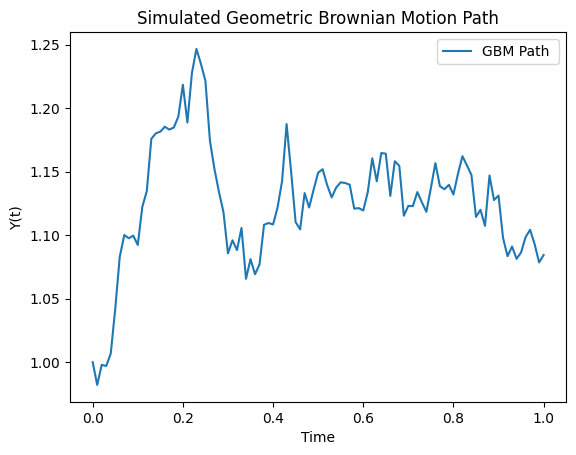

In [2]:
import pygbm_x as pg
simulator = pg.GBM_simulator(y0=1.0, mu=0.05, sigma=0.2)
t_values, y_values = simulator.simulate_path(T=1.0, N=100)
simulator.plot_path(t_values, y_values)

#### Creating wheels for multiple platforms

- We use cibuildwheel to do this, it runs on Mac, Linux and Windows. 
- On Mac and Windows, it can run docker containers to build Linux wheels.
- We can install it with:

In [ ]:
pip install cibuildwheel

To build the wheel we can then do, from the root of the package:

In [ ]:
CIBW_BUILD="cp311-manylinux_x86_64" CIBW_ARCHS="x86_64" cibuildwheel --platform linux

Above we speficy the Python version and the architecture we want to build for. Note that for this to run on Mac/Windows, docker needs to run in the background (i.e., to be switched on).

The wheel is built in the wheelhouse folder.

#### Turning C/C++ into Python

Cython can also be used to turn C/C++ libraries into Python packages. This is extremely useful because it means that you can use Python syntax to call C/C++ functions (generally much more optimised). Notable examples where this is useful is for codes that rely on OpenMP parallelisation, or that use BLAS/LAPACK libraries.

### Differentiable Programming

- Writing differentiable code is crucial for machine learning pipelines as it allows for efficient, machine-precision gradient computations. 
- This is referred to as automatic differentiation and is based on the chain rule. 
- PyTorch, TensorFlow and Jax provide differentiable programming frameworks available in Python, i.e., they can be imported in Python code. 
- We will look at a simple example in PyTorch:

Set up:

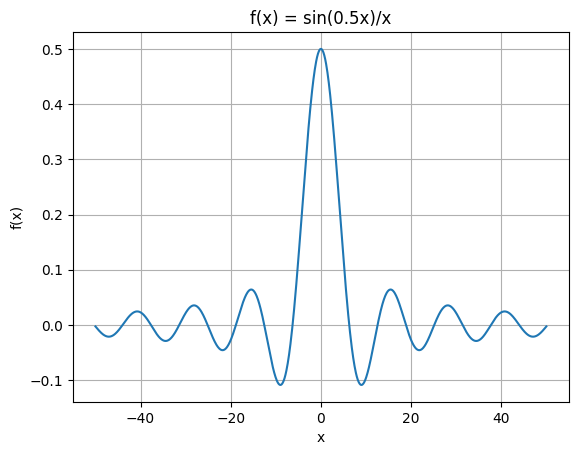

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Create x values
x = np.linspace(-50, 50, 1000)
# Set a
a = 0.5

# consider this function f(x)
f = np.sin(a * x) / x

plt.figure()
plt.plot(x, f)
plt.grid(True)
plt.title(f'f(x) = sin({a}x)/x')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


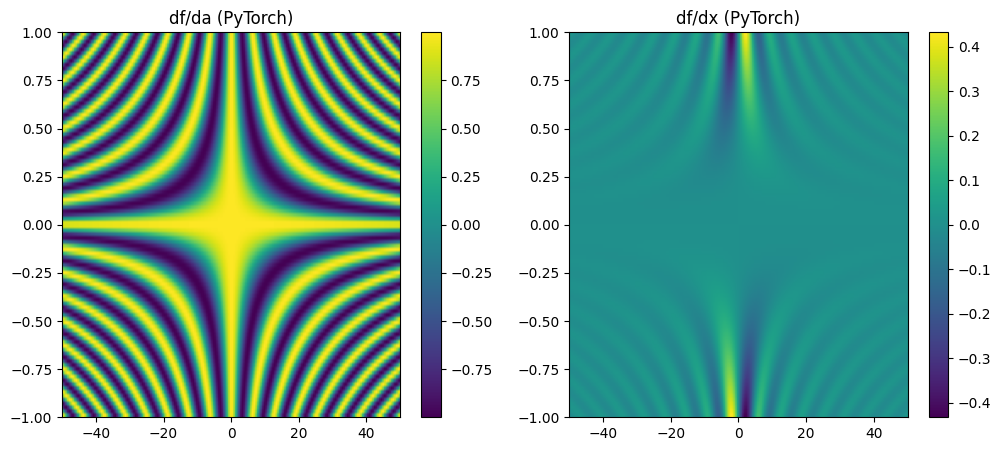

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the function in PyTorch
def f(a, x):
    return torch.sin(a * x) / x #because we use PyTorch function, PyTorch by default enables gradient computation with respect to this function

# Create grid object for a and x in PyTorch
a = torch.linspace(-1, 1, 100, requires_grad=True) #requires_grad=True denotes we requires gradient calculation later at each value of a (partial deriviative at each a)
x = torch.linspace(-50, 50, 200, requires_grad=True) #requires_grad=True denotes we requires gradient calculation later at each value of x (partial deriviative at each x)
A, X = torch.meshgrid(a, x, indexing='ij')

# Compute the function
F = f(A, X)

# Compute derivatives
grad_a, grad_x = torch.autograd.grad(
    F.sum(), #autograd.grad can only compute derivatives of scalar-valued functions, so we sum over F_ax, because differentiation is linear, this gives us a partial derivative for each element of A and X.
    [A, X], #w want partial derivatives with respect to tensor A (partial derivatives at each a), and tensor X (partial derivatives at each x)
    create_graph=True # see https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/
) 
# grad_a: partial derivation w.r.t A at each local (x, a)
# grad_x: partial derivation w.r.t X at each local (x, a)

# Plot the partial derivatives (at each (x,a) local point)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("df/da (PyTorch)")
plt.imshow(grad_a.detach().numpy(), extent=[-50, 50, -1, 1], aspect='auto') #.detach() removes gradient-tracking, .numpy() convert to numpy array
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("df/dx (PyTorch)")
plt.imshow(grad_x.detach().numpy(), extent=[-50, 50, -1, 1], aspect='auto')
plt.colorbar()

plt.show()